In [1]:
# Import Modules
from CenterOfMass import CenterOfMass
from ReadFile import Read
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.constants import G
from scipy.optimize import curve_fit

In [2]:
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)

In [3]:
class MassProfile:
    def __init__(self, galaxy, snap):
        """
        Class to calculate the Mass Profile of a Galaxy at a specific snapshot.

            PARAMETERS
            ----------
            galaxy: 'str'
                Specifies which galaxy we are analyzing.
                e.g. 'MW', 'M31', or 'M33
            snap: 'int'
                Number which specifies the snapshot number of the galaxy to analyze
                e.g. 0, 1, etc.
        """
        # Store the name of the galaxy
        self.gname = galaxy
        
        # add a string of the filenumber to the value "000"
        ilbl = "000"+str(snap)
        # Remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'

        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)

        # store the mass and positions of the particles
        self.m = self.data['m']
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc

    def TotalMass(self, ptype):
        index = np.where(self.data['type']==ptype)
        total_mass = np.sum(self.m[index])
        return total_mass

    def MassEnclosed(self, ptype, radii):
        """
        Function which determines the mass enclosed within the galaxy for a list of radii

        Inputs:
            pytpe: number indicating the particle type
                   Halo Type = 1.0
                   Disk Type = 2.0
                   Bulge Type = 3.0
                   
            radii: numpy array of various radii
                   (kpc)

        Outputs:
            masses: numpy array of astropy quantities of the mass enclosed 
                    within the radii specified in the input
                    (MSun)
        """

        # Center Of Mass of the galaxy
        # Using the disk particles to calculate the center of mass
        COM = CenterOfMass(self.filename, 2)

        # Center of Mass Position
        COM_p = COM.COM_P(0.1)

        # Find all the particles of the specified type
        index = np.where(self.data['type']==ptype)

        # Find the masses and x, y, z, positions of all
        # the particles of the specified type
        pm = self.m[index]
        px = self.x[index]
        py = self.y[index]
        pz = self.z[index]
        pdist = np.sqrt(px**2 + py**2 + pz**2)

        # Initialize an array of the same size as radii
        # but whose values are all 0
        masses = np.zeros_like(radii)

        # Loop through the radii array and find the 
        # mass enclosed within that radius in the galaxy
        for i, r in enumerate(radii):
            dist_index = np.where(pdist < r*u.kpc)

            mass_enclosed = np.sum(pm[dist_index])

            masses[i] = mass_enclosed

        # Return the masses with the correct units
        return masses*1e10*u.Msun

    def MassEnclosedTotal(self, radii):
        if self.gname == "M33":
            HaloMass = self.MassEnclosed(1, radii)
            DiskMass = self.MassEnclosed(2, radii)
            TotalMass = HaloMass + DiskMass
        else:
            HaloMass = self.MassEnclosed(1, radii)
            DiskMass = self.MassEnclosed(2, radii)
            BulgeMass = self.MassEnclosed(3, radii)
            TotalMass = HaloMass + DiskMass + BulgeMass
        return TotalMass

    def HernquistMass(self, radius, a, Mhalo):
        M = Mhalo*(radius**2)/((a+radius)**2)
        return M

    def CircularVelocity(self, ptype, radii):      
        enclosed_masses = self.MassEnclosed(ptype, radii)
        speeds = np.sqrt(G*enclosed_masses/radii)
        return speeds

    def CircularVelocityTotal(self, radii):
        TotalMass = self.MassEnclosedTotal(radii)
        speeds = np.sqrt(G*TotalMass/radii)
        return speeds

    def HernquistVCirc(self, radius, a, MHalo):
        HMass = self.HernquistMass(radius, a, MHalo)
        HVCirc = np.sqrt(G*HMass/radius)
        return np.round(HVCirc, 2)     

In [4]:
MW = MassProfile("MW", 0)
M31 = MassProfile("M31", 0)
M33 = MassProfile("M33", 0)

In [5]:
r = np.arange(0.1, 30.5, 0.01)

In [6]:
def HernquistProfile(radius, a, MHalo):
    M = MHalo*(radius**2)/((a+radius)**2)
    return M

# Mass Profiles

## Milky Way

In [7]:
MW_Halo_MassEnclosed = MW.MassEnclosed(1, r)
MW_Disk_MassEnclosed = MW.MassEnclosed(2, r)
MW_Bulge_MassEnclosed = MW.MassEnclosed(3, r)
MW_Total_MassEnclosed = MW.MassEnclosedTotal(r)

In [8]:
MW_DM_Mass = MW.TotalMass(1)*1e10*u.Msun

In [9]:
def HernquistMassMW(radii, a):
    return HernquistProfile(radii, a, MHalo=MW_DM_Mass.value)

In [10]:
popt, pcov = curve_fit(HernquistMassMW, r, MW_Halo_MassEnclosed.value, p0=[65])

In [11]:
a_MW = popt[0]

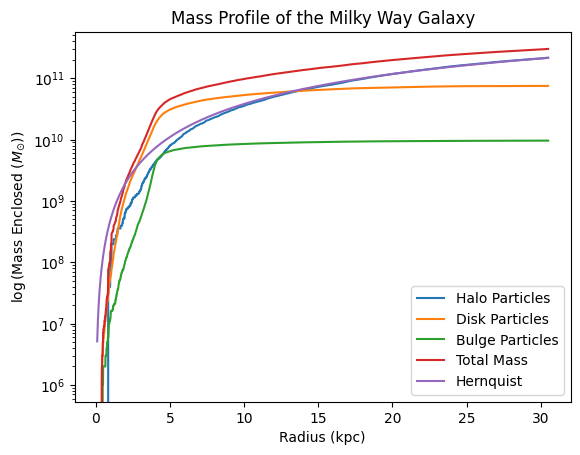

In [12]:
fig, ax = plt.subplots()
ax.semilogy(r, MW_Halo_MassEnclosed, label="Halo Particles")
ax.semilogy(r, MW_Disk_MassEnclosed, label="Disk Particles")
ax.semilogy(r, MW_Bulge_MassEnclosed, label="Bulge Particles")
ax.semilogy(r, MW_Total_MassEnclosed, label="Total Mass")
ax.semilogy(r, HernquistMassMW(r, a_MW), label="Hernquist")
ax.legend()

ax.set_title("Mass Profile of the Milky Way Galaxy")
ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"$\log$(Mass Enclosed ($M_{\odot}$))")
plt.show()

## Andromeda M31

## Triangulum M33

# Rotation Curves

## Milky Way

In [13]:
MW_Halo_V = MW.CircularVelocity(1, r)
MW_Disk_V = MW.CircularVelocity(2, r)
MW_Bulge_V = MW.CircularVelocity(3, r)
MW_Total_V = MW.CircularVelocityTotal(r)

In [14]:
MW_Hernquist_V = MW.HernquistVCirc(r, a_MW, MW_DM_Mass)

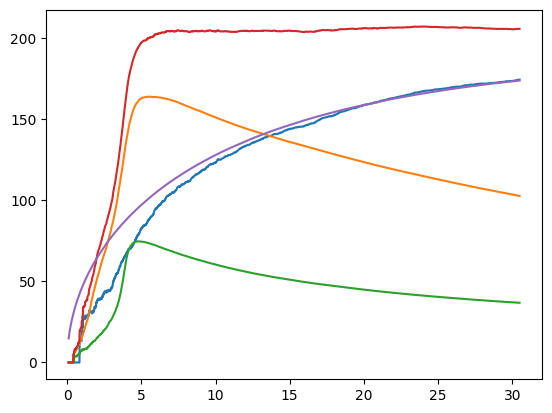

In [15]:
fig, ax = plt.subplots()
ax.plot(r, MW_Halo_V, label="Halo")
ax.plot(r, MW_Disk_V, label="Disk")
ax.plot(r, MW_Bulge_V, label="Bulge")
ax.plot(r, MW_Total_V, label="Total")
ax.plot(r, MW_Hernquist_V, label="Hernquist")
plt.show()

## Andromeda M31

## Triangulum M33